In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from collections import defaultdict
import os

file_counts = defaultdict(int)

for dirname, _, filenames in os.walk('/kaggle/input/mri-scan-images'):
    file_counts[dirname] += len(filenames)

# Display total files per subdirectory
for dir_name, count in file_counts.items():
    print(f"{dir_name}: {count} files")


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mri-scan-images: 0 files
/kaggle/input/mri-scan-images/Training: 0 files
/kaggle/input/mri-scan-images/Training/pituitary: 1457 files
/kaggle/input/mri-scan-images/Training/notumor: 1595 files
/kaggle/input/mri-scan-images/Training/meningioma: 1339 files
/kaggle/input/mri-scan-images/Training/glioma: 1321 files
/kaggle/input/mri-scan-images/Testing: 0 files
/kaggle/input/mri-scan-images/Testing/pituitary: 300 files
/kaggle/input/mri-scan-images/Testing/notumor: 405 files
/kaggle/input/mri-scan-images/Testing/meningioma: 306 files
/kaggle/input/mri-scan-images/Testing/glioma: 300 files


**IMPORT PACKAGES**

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import glob


**DEFINE DATASET**

In [4]:
# Define dataset directories
train_dir = "/kaggle/input/mri-scan-images/Training"
test_dir = "/kaggle/input/mri-scan-images/Testing"

# Get all image paths without printing them
train_image_paths = glob.glob(f"{train_dir}/*/*.jpg")
test_image_paths = glob.glob(f"{test_dir}/*/*.jpg")



**DATA AUGMENTATION**

In [5]:

# Image size (Xception requires 299x299)
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32

# Data Augmentation (Fine-tuned)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,      
    width_shift_range=0.3,  
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data
train_loader = train_datagen.flow_from_directory(
    train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Convert Testing Data to DataFrame for Splitting
test_loader = test_datagen.flow_from_directory(
    test_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# Create DataFrame of Image Paths & Classes
file_paths = [os.path.join(test_dir, fname) for fname in test_loader.filenames]
ts_df = pd.DataFrame({"Class Path": file_paths, "Class": test_loader.classes})
ts_df["Class"] = ts_df["Class"].astype(str)  # Convert to string

# Split Testing Data into Validation & Final Test (50% each)
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df["Class"])

# Load Validation Data
valid_gen = test_datagen.flow_from_dataframe(valid_df, x_col="Class Path",
                                             y_col="Class", batch_size=BATCH_SIZE,
                                             target_size=IMAGE_SIZE, class_mode='categorical')

# Load Final Test Data
test_gen = test_datagen.flow_from_dataframe(ts_df, x_col="Class Path",y_col="Class", batch_size=16,target_size=IMAGE_SIZE, 
                                            class_mode='categorical',
                                            shuffle=False)

# Print Class Labels
class_labels = list(train_loader.class_indices.keys())
print(f"Class Labels: {class_labels}")




Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Class Labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


**DEFINE THE MODEL**

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

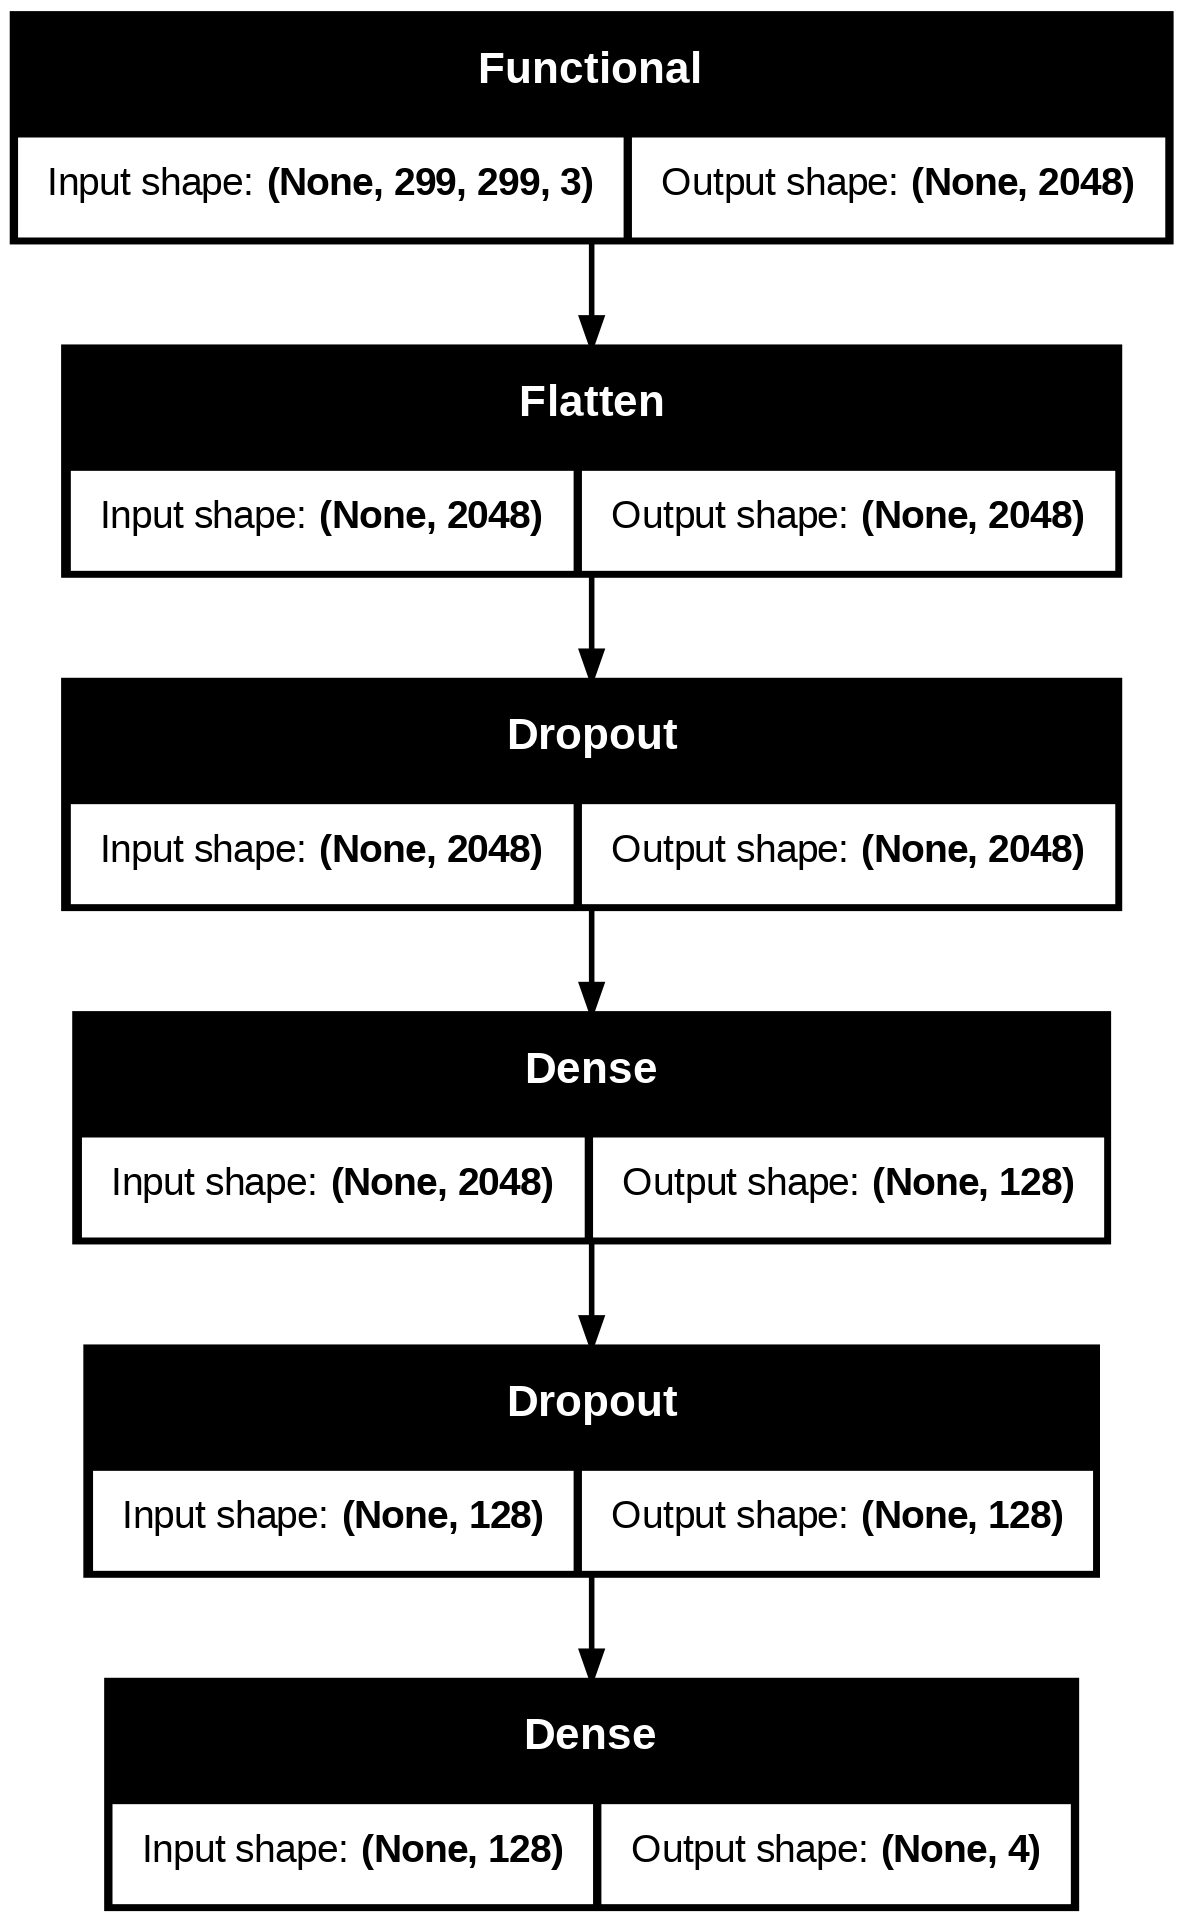

In [6]:
# Define input shape
input_shape = (299, 299, 3)

# Load Pretrained Xception Model
base_model = Xception(include_top=False, weights="imagenet",
                      input_shape=input_shape, pooling='max')


# Define Model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

# Compile Model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Print Model Summary
model.summary()

# Plot Model Architecture
tf.keras.utils.plot_model(model, show_shapes=True)

In [7]:
# Early Stopping & ReduceLROnPlateau Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# Train Model with Early Stopping & ReduceLROnPlateau
hist = model.fit(
    train_loader,
    epochs=12,  # EarlyStopping will stop training when needed
    validation_data=valid_gen,
    shuffle=False,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.4775 - loss: 1.2075 - precision: 0.6811 - recall: 0.2741 - val_accuracy: 0.8412 - val_loss: 0.4435 - val_precision: 0.8724 - val_recall: 0.8244 - learning_rate: 0.0010
Epoch 2/12
179/179 ━━━━━━━━━━━━━━━━━━━━ 153s 849ms/step - accuracy: 0.9356 - loss: 0.2107 - precision: 0.9475 - recall: 0.9227 - val_accuracy: 0.9298 - val_loss: 0.2134 - val_precision: 0.9436 - val_recall: 0.9191 - learning_rate: 0.0010
Epoch 3/12
179/179 ━━━━━━━━━━━━━━━━━━━━ 151s 842ms/step - accuracy: 0.9626 - loss: 0.1072 - precision: 0.9674 - recall: 0.9599 - val_accuracy: 0.9618 - val_loss: 0.1172 - val_precision: 0.9633 - val_recall: 0.9618 - learning_rate: 0.0010
Epoch 4/12
179/179 ━━━━━━━━━━━━━━━━━━━━ 153s 850ms/step - accuracy: 0.9703 - loss: 0.0973 - precision: 0.9736 - recall: 0.9663 - val_accuracy: 0.9695 - val_loss: 0.0802 - val_precision: 0.9709 - val_recall: 0.9679 - learning_rate: 0.0010
Epoch 5/12
179/179 ━━━━━━━━━━━━━━━━━━━━ 155s 862ms/step - accu

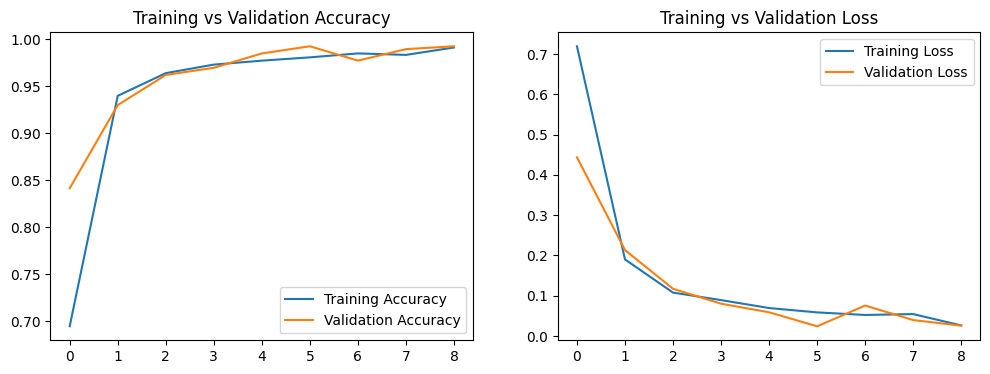

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves(hist):
    plt.figure(figsize=(12, 4))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title("Training vs Validation Accuracy")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title("Training vs Validation Loss")

    plt.show()

# Call function after training
plot_training_curves(hist)

**Summary of Training Performance**

**Accuracy:** Both training and validation accuracy reach ~99%, with minor fluctuations, indicating strong generalization.

**Loss:** Both losses decrease consistently, with slight validation loss variation.

**Conclusion:** The model performs exceptionally well with no clear overfitting.

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       150
           1       0.98      0.99      0.99       153
           2       1.00      1.00      1.00       203
           3       1.00      1.00      1.00       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



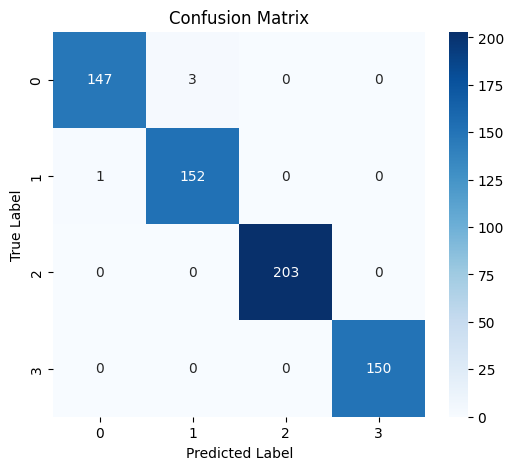

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predicted labels
y_true = test_gen.classes  # True labels from test set
y_pred_prob = model.predict(test_gen)  # Get predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [10]:
model.save("/kaggle/working/brain_tumor_xception_model.h5")
